In [2]:
import pandas as pd
import numpy as np
import gensim.models.word2vec as w2v
import multiprocessing
import os
import re
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn.manifold

In [3]:
songs = pd.read_csv("../datasets/songdata.csv", header=0)
#songs.head()
songs = songs[songs.artist != 'Lata Mangeshkar']
songs.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [4]:
arts_list = songs['artist'].unique()
print(len(arts_list))

642


In [5]:
my_arts=['The Beatles','Maroon 5','Lana Del Rey','Chris Brown','Green Day','David Guetta','Ellie Goulding','Ed Sheeran']

In [6]:
text_lenght = [0]*(len(my_arts))                                 # creating the subtable
my_lyrics = songs[songs.artist =='Maroon 5']
text_lenght[0] = len(my_lyrics)

for i in range(0, len(my_arts)):
    text_lenght[i]= len(songs[songs['artist']==my_arts[i]]['text'])
    my_lyrics = my_lyrics.append(songs[songs.artist ==my_arts[i]])
    i+=1

print(text_lenght)                               # Number of songs per chosen artist  
print(len(my_lyrics))  

[178, 110, 113, 145, 174, 63, 77, 53]
1023


,artist,song,link,text
12520,Maroon 5,Can't Stop,/m/maroon+5/cant+stop_20419103.html,All alone in my room think of you at a rate th...
12521,Maroon 5,Harder To Breathe,/m/maroon+5/harder+to+breathe_20089506.html,How dare you say that my behavior is unaccepta...
12522,Maroon 5,Highway To Hell,/m/maroon+5/highway+to+hell_10175468.html,"Living easy, livin' free \nSeason ticket, on ..."
12523,Maroon 5,If I Fell,/m/maroon+5/if+i+fell_10175467.html,If I fell in love with you \nWould you promis...
12524,Maroon 5,If You Only Knew,/m/maroon+5/if+you+only+knew_10175490.html,I wake up \nThoughts of you \nTattooed to my...


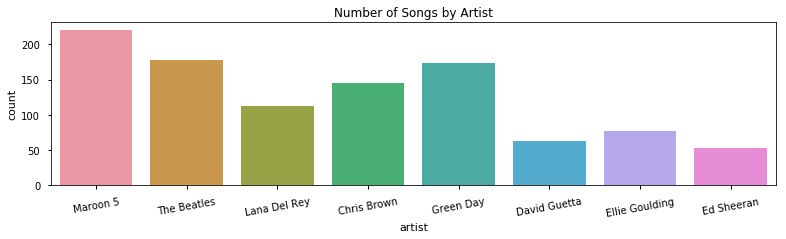

In [7]:
sns.set_context("notebook", font_scale=1.0)
sns.set_palette('cubehelix',4)         
plt.figure(figsize=(13,3))
plt.title('Number of Songs by Artist')
g = sns.countplot(my_lyrics['artist'])
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=10)                                        
my_lyrics.head()

In [8]:
print(arts_list[:10])

['ABBA' 'Ace Of Base' 'Adam Sandler' 'Adele' 'Aerosmith' 'Air Supply'
 'Aiza Seguerra' 'Alabama' 'Alan Parsons Project' 'Aled Jones']


In [17]:
from io import StringIO
warray = [['']]*8                  # Picking lists of most favorite words by artist
fav_words = [['']]*8
word_cnt = [0]*8
tfidf = TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=True, stop_words='english')
i=0                                                    
for artist, sngs in my_lyrics.groupby('artist'):
    my_texts = songs[songs['artist']==my_arts[i]]['text']
    tfidf.fit_transform(my_texts)
    cnt = np.sum(tfidf.transform(sngs['text']).toarray(), axis=0)
    warray[i] = tfidf.get_feature_names()
    word_cnt[i] = len(warray[i])
    sort_freq = np.argsort(cnt.flatten())[::-1]   
    fav_words[i] = [tfidf.get_feature_names()[idx] for idx in sort_freq.tolist()[:40]]
    print(my_arts[i], "has the most favorite words :",fav_words[i],
         'and the number of unique words in all songs is:', word_cnt[i])
    i+=1 

The Beatles has the most favorite words : ['girl', 'wanna', 'don', 'love', 'chorus', 'like', 'baby', 'know', 'cause', 'just', 'got', 'let', 'need', 'ya', 'ain', 'oh', 'yeah', 'gotta', 'want', 'make', 'll', 'body', 'right', 'heart', 'tell', 'say', 'brown', 'way', 'come', 'think', 'time', 'man', 'money', 'bout', 'look', 'bad', 'life', 'gonna', 'hey', 'did'] and the number of unique words in all songs is: 2028
Maroon 5 has the most favorite words : ['love', 'wanna', 'let', 'don', 'party', 'got', 'oh', 'dance', 'hear', 'just', 'hey', 'baby', 'yeah', 'make', 'like', 'feel', 'chorus', 'people', 'know', 'world', 'come', 'won', 'll', 'night', 'lights', 've', 'money', 'believe', 'right', 'hands', 'gotta', 'music', 'floor', 'way', 'life', 'bang', 'girl', 'live', 'tonight', 'say'] and the number of unique words in all songs is: 1803
Lana Del Rey has the most favorite words : ['ll', 'love', 'oh', 'home', 'just', 'like', 'know', 'let', 'eyes', 'come', 'away', 'hold', 'heart', 'don', 'long', 'feel',

In [15]:
comb_texts = ['']*8            # concatenated texts of all songs by the artist
comb_length = [0]*8
i=0
j=0
mn=0
while (i!=sum(text_lenght)):
    comb_texts[j] += (my_lyrics.iloc[i]['text'])
    if (i == text_lenght[j]+ mn ):
        mn+=text_lenght[j]
        j+=1
    i+=1 
for l in range (0,8):
    comb_length[l] = len(comb_texts[l])    
print(comb_length)

[223098, 99931, 163169, 238686, 284453, 68489, 83079, 71653]


In [18]:
artists_stats = pd.DataFrame()
artists_stats['artist'] = my_arts
artists_stats['songs'] = text_lenght
artists_stats['words'] = word_cnt
artists_stats['all_length'] = comb_length
artists_stats

,artist,songs,words,all_length
0,The Beatles,178,2028,223098
1,Maroon 5,110,1803,99931
2,Lana Del Rey,113,2254,163169
3,Chris Brown,145,3251,238686
4,Green Day,174,2937,284453
5,David Guetta,63,1070,68489
6,Ellie Goulding,77,1479,83079
7,Ed Sheeran,53,1614,71653


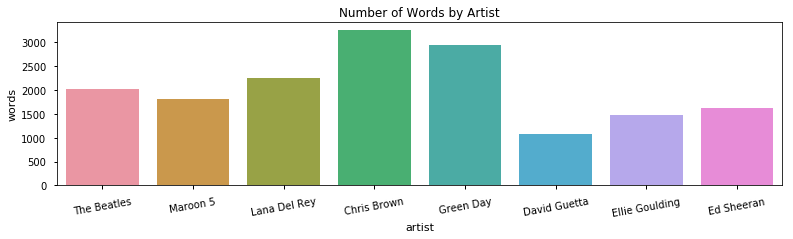

In [19]:
sns.set_context("notebook",font_scale=1.0)
plt.figure(figsize=(13,3))
plt.title('Number of Words by Artist')
g = sns.barplot( x='artist', y='words', data=artists_stats )
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=10)

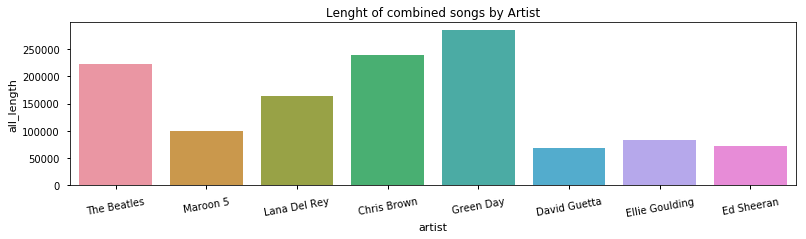

In [20]:
sns.set_context("notebook",font_scale=1.0)
plt.figure(figsize=(13,3))
plt.title('Lenght of combined songs by Artist')
g = sns.barplot( x='artist', y='all_length', data=artists_stats )
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=10)

In [29]:
topics = ['life','death','love','hate','dream','hell','light','dark',
          'heart','kill','party','miss','leave','break','lost']
topic_cnt = np.zeros((8,15), int)
i = 0                                    # setting short vocabulary positive/negative pairs
j = 0                                 
for text in comb_texts:
    for topic in topics:
        topic_cnt[i][j] = text.count(topic)
        j+=1
    j=0    
    i+=1
    
# def score_count(a,b,c,d,e,f,g,h,k,l):
#     return (100*(a+b+c+d+e)/(f+g+h+k+l))  

In [31]:
freq_df = pd.DataFrame(topic_cnt)
freq_df.rename(columns=lambda x: topics[int(x)], inplace=True)
freq_df['artist'] = my_arts
col_to_keep= ['artist','life','death','love','hate','dream','hell','light','dark',
          'heart','kill','party','miss','leave','break','lost']
freq_df = freq_df[col_to_keep]
# freq_df['mood'] =score_count(freq_df.life,freq_df.love,freq_df.dream,freq_df.light,
#                              freq_df.heart,freq_df.death,freq_df.hate,freq_df.hell,
#                              freq_df.dark,freq_df.kill)
freq_df                      # table of word frequencies by artist


,artist,life,death,love,hate,dream,hell,light,dark,heart,kill,party,miss,leave,break,lost
0,The Beatles,46,4,367,5,26,57,53,32,91,28,7,20,75,25,25
1,Maroon 5,28,0,228,12,26,15,22,5,32,1,3,7,26,8,6
2,Lana Del Rey,34,5,241,5,12,26,71,28,82,28,1,14,41,17,20
3,Chris Brown,76,5,389,33,52,12,79,28,53,18,48,19,52,24,11
4,Green Day,66,8,434,51,44,16,50,2,148,24,34,34,69,57,25
5,David Guetta,39,5,28,5,19,14,19,4,34,14,2,2,5,3,17
6,Ellie Goulding,30,4,119,17,9,20,47,3,37,7,53,5,16,10,20
7,Ed Sheeran,27,1,140,7,21,1,19,5,42,0,43,2,7,35,18


In [48]:
print (len(my_lyrics))
# print(songs.loc[songs.artist=='Ellie Goulding'])
# my_lyrics.loc[my_lyrics['artist']=='Maroon 5']['text']

1023


In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0, stop_words = 'english')

arts_features= ['']*8            # concatenated texts of all songs by the artist
i=0
top_n = 25

while (i!=len(my_arts)):
    art_text= my_lyrics.loc[my_lyrics['artist']==my_arts[i]]['text']
    tfidf= tf.fit_transform(art_text)
    features=tf.get_feature_names()
    indices = np.argsort(tf.idf_)[::-1]
    top_features = [features[i] for i in indices[:top_n]]
    arts_features[i]=top_features
    print (my_arts[i] ,'\n', arts_features[i],'\n')
    i+=1

The Beatles 
 ['zu mir', 'head tuesday', 'headed pool', 'headed', 'head yawning', 'head won', 'head wish', 'head way', 'head try', 'helloa hela', 'head threw', 'head silly', 'head sea', 'head sand', 'head look', 'head like', 'heading', 'heading home', 'health dr', 'health said', 'hear balalaika', 'hear clock', 'hear comes', 'hear commonwealth', 'hear does'] 

Maroon 5 
 ['zero like', 'impulsive makes', 'hard standing', 'hard stay', 'hard sunday', 'hard time', 'hard tried', 'hard try', 'hard waiting', 'harder bitter', 'harder breathe', 'harder everyday', 'harder harder', 'harder ooh', 'hardly', 'hardly know', 'hashtag', 'hashtag boo', 'hate', 'hate like', 'hate love', 'hates', 'hates life', 'hating', 'hating ll'] 

Lana Del Rey 
 ['zoom miles', 'got want', 'got trouble', 'got thinking', 'got think', 'got things', 'got tested', 'got sweet', 'got sun', 'got summertime', 'got summer', 'got struggling', 'got store', 'got stick', 'got skeletons', 'got shit', 'got sent', 'got ve', 'got war', 

In [32]:
text_corpus = []
for song in songs['text']:
    words = song.lower().split()
    text_corpus.append(words)



# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 50
# Minimum word count threshold.
min_word_count = 1

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7


downsampling = 1e-1

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

songs2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

songs2vec.build_vocab(text_corpus)
print (len(text_corpus))

57618


In [58]:
print (text_corpus[0])

['look', 'at', 'her', 'face,', "it's", 'a', 'wonderful', 'face', 'and', 'it', 'means', 'something', 'special', 'to', 'me', 'look', 'at', 'the', 'way', 'that', 'she', 'smiles', 'when', 'she', 'sees', 'me', 'how', 'lucky', 'can', 'one', 'fellow', 'be?', "she's", 'just', 'my', 'kind', 'of', 'girl,', 'she', 'makes', 'me', 'feel', 'fine', 'who', 'could', 'ever', 'believe', 'that', 'she', 'could', 'be', 'mine?', "she's", 'just', 'my', 'kind', 'of', 'girl,', 'without', 'her', "i'm", 'blue', 'and', 'if', 'she', 'ever', 'leaves', 'me', 'what', 'could', 'i', 'do,', 'what', 'could', 'i', 'do?', 'and', 'when', 'we', 'go', 'for', 'a', 'walk', 'in', 'the', 'park', 'and', 'she', 'holds', 'me', 'and', 'squeezes', 'my', 'hand', "we'll", 'go', 'on', 'walking', 'for', 'hours', 'and', 'talking', 'about', 'all', 'the', 'things', 'that', 'we', 'plan', "she's", 'just', 'my', 'kind', 'of', 'girl,', 'she', 'makes', 'me', 'feel', 'fine', 'who', 'could', 'ever', 'believe', 'that', 'she', 'could', 'be', 'mine?', 

In [59]:
tot_ex= (sum(len(ix) for ix in text_corpus))

In [60]:
songs2vec.train(text_corpus,total_examples =songs2vec.corpus_count, epochs = songs2vec.iter)

if not os.path.exists("trained"):
    os.makedirs("trained")

songs2vec.save(os.path.join("trained", "songs2vectors.w2v"))

--- 196.4637370109558 seconds ---


In [61]:
songs2vec = w2v.Word2Vec.load(os.path.join("trained", "songs2vectors.w2v"))

In [62]:
print(songs2vec['un-right'])
def songVector(row):
    vector_sum = 0
    words = row.lower().split()
    for word in words:
        vector_sum = vector_sum + songs2vec[word]
    vector_sum = vector_sum.reshape(1,-1)
    normalised_vector_sum = sklearn.preprocessing.normalize(vector_sum)
    return normalised_vector_sum

songs['song_vector'] = songs['text'].apply(songVector)

[ 0.10520732 -0.11905227 -0.02264868  0.08763389 -0.01965734  0.00842788
  0.30109677 -0.09839586  0.05090872  0.01883112 -0.03365206 -0.03687896
 -0.06137804 -0.10086443  0.0539593  -0.0206394  -0.1544895   0.00073664
  0.01824212 -0.04559037 -0.21099392 -0.0634938   0.09549674  0.1429027
  0.05977608 -0.10658271  0.03214298  0.06683779 -0.04891288  0.00080828
 -0.08943485 -0.14408661 -0.05336811 -0.03402016 -0.07458282  0.05776213
 -0.24752416 -0.11424237 -0.02642372 -0.04283319  0.05304714  0.06557309
  0.03975649  0.12989974 -0.04361546  0.14711414 -0.09886594 -0.09435517
  0.14133896 -0.05576665]


In [63]:
song_vectors = []
from sklearn.model_selection import train_test_split

train, test = train_test_split(songs, test_size = 0.9)


for song_vector in train['song_vector']:
    song_vectors.append(song_vector)

train.head(10)



,artist,song,link,text,song_vector
37611,Jennifer Lopez,Alive,/j/jennifer+lopez/alive_20248164.html,Time goes slowly now in my life \nFear no mor...,"[[0.182276, -0.0122716, -0.0729304, 0.128287, ..."
43888,Michael W. Smith,Grace,/m/michael+w+smith/grace_20486290.html,I was lost when ya found me here \nYou pulled...,"[[0.183881, -0.0194191, -0.114408, 0.0611193, ..."
52343,Sting,Sister Moon,/s/sting/sister+moon_20132065.html,Sister moon will be my guide \nIn your blue b...,"[[0.16249, -0.0583391, -0.0837425, 0.0821369, ..."
21748,X,Love Shack,/x/x/love+shack_20533564.html,"I was with you when you wrote it, and I liked ...","[[0.146743, -0.0330149, -0.12499, 0.121757, 0...."
51386,Savage Garden,Violet,/s/savage+garden/violet_20122144.html,If there's a way that you could \nBe everythi...,"[[0.158255, -0.0300891, -0.0950673, 0.105918, ..."
34761,Green Day,Rock N' Roll Girlfriend,/g/green+day/rock+n+roll+girlfriend_10138717.html,(Written and sung by Tre Cool) \n \nI got a ...,"[[0.132093, -0.0618552, -0.00618893, 0.075262,..."
46518,Offspring,Not The One,/o/offspring/not+the+one_20102670.html,I'm not the one who made the world what it is ...,"[[0.131155, -0.0448686, -0.0842278, 0.105903, ..."
1321,Bette Midler,One Monkey Don't Stop No Show,/b/bette+midler/one+monkey+dont+stop+no+show_2...,My baby jumped up this morning \n'N sat on th...,"[[0.162903, -0.0450428, -0.117086, 0.0904067, ..."
22821,ZZ Top,What's Up With That,/z/zz+top/whats+up+with+that_20149286.html,Well how much blues do you use \nBefore you u...,"[[0.142724, -0.0356683, -0.0818694, 0.146794, ..."
12790,Metallica,Battery,/m/metallica/battery_20092039.html,"Lashing out the action, returning the reaction...","[[0.157044, -0.0972807, -0.0785512, 0.0464017,..."


In [67]:
X = np.array(song_vectors).reshape((5761, 50))
tsne = sklearn.manifold.TSNE(n_components=2, n_iter=600, random_state=1, verbose=2)

all_word_vectors_matrix_2d = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5761 samples in 0.010s...
[t-SNE] Computed neighbors for 5761 samples in 3.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5761
[t-SNE] Computed conditional probabilities for sample 2000 / 5761
[t-SNE] Computed conditional probabilities for sample 3000 / 5761
[t-SNE] Computed conditional probabilities for sample 4000 / 5761
[t-SNE] Computed conditional probabilities for sample 5000 / 5761
[t-SNE] Computed conditional probabilities for sample 5761 / 5761
[t-SNE] Mean sigma: 0.052784
[t-SNE] Computed conditional probabilities in 0.476s
[t-SNE] Iteration 50: error = 87.4051514, gradient norm = 0.0222114 (50 iterations in 10.666s)
[t-SNE] Iteration 100: error = 87.3129730, gradient norm = 0.0339411 (50 iterations in 9.914s)
[t-SNE] Iteration 150: error = 87.0967178, gradient norm = 0.0210869 (50 iterations in 7.736s)
[t-SNE] Iteration 200: error = 87.0592041, gradient norm = 0.0223038 (50 iterations in 11.285s)


In [68]:
df=pd.DataFrame(all_word_vectors_matrix_2d,columns=['X','Y'])

df.head(10)

train.head()

df.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [75]:
X.shape

(5761, 50)

In [76]:
all_word_vectors_matrix_2d.shape

(5761, 2)

In [69]:
two_dimensional_songs = pd.concat([train, df], axis=1)

two_dimensional_songs.head()

,artist,song,link,text,song_vector,X,Y
0,Jennifer Lopez,Alive,/j/jennifer+lopez/alive_20248164.html,Time goes slowly now in my life \nFear no mor...,"[[0.182276, -0.0122716, -0.0729304, 0.128287, ...",-0.355932,-35.207512
1,Michael W. Smith,Grace,/m/michael+w+smith/grace_20486290.html,I was lost when ya found me here \nYou pulled...,"[[0.183881, -0.0194191, -0.114408, 0.0611193, ...",-21.652693,-5.782600
2,Sting,Sister Moon,/s/sting/sister+moon_20132065.html,Sister moon will be my guide \nIn your blue b...,"[[0.16249, -0.0583391, -0.0837425, 0.0821369, ...",-19.687382,-7.356620
3,X,Love Shack,/x/x/love+shack_20533564.html,"I was with you when you wrote it, and I liked ...","[[0.146743, -0.0330149, -0.12499, 0.121757, 0....",10.254518,9.597961
4,Savage Garden,Violet,/s/savage+garden/violet_20122144.html,If there's a way that you could \nBe everythi...,"[[0.158255, -0.0300891, -0.0950673, 0.105918, ...",1.423587,-7.639852


In [77]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

import plotly.graph_objs as go

trace1 = go.Scatter(
    y = two_dimensional_songs['Y'],
    x = two_dimensional_songs['X'],
    text = two_dimensional_songs['song'],
    mode='markers',
    marker=dict(
        size='7',
        color = np.random.randn(5717), #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)
data = [trace1]

iplot(data)

In [78]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

import plotly.graph_objs as go

trace1 = go.Scatter(
    y = two_dimensional_songs['Y'],
    x = two_dimensional_songs['X'],
    text = two_dimensional_songs['song'],
    mode='markers',
    marker=dict(
        size='7',
        color = np.random.randn(5717), #set color equal to a variable
        colorscale='RdYlBl',
        showscale=True
    )
)
data = [trace1]

iplot(data)